# Notebook to make gif 2: time evolution of corner plots

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

style.use('plotting.mplstyle')

import seaborn as sns
cp = sns.color_palette('colorblind') 
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../scripts')
from helper_functions import *

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load data 

Posterior samples

In [1]:
td_samples, tcutoffs = load_posterior_samples(data_dir)

Turn into a dictionary to plot

In [2]:
def get_plotting_dict(samples):
     
    # downsample to speed up plotting
    target_length = min(len(samples['mtotal']), 7000)
    mask = np.random.choice(len(samples['mtotal']), size=target_length, replace=False)
    
    # get mass samples
    mtot = samples['mtotal'][mask]
    q = samples['q'][mask]
    m1, m2 = m1m2_from_mtotq(mtot, q)
    
    # get chi_p
    chip = chi_precessing(m1, samples['chi1'][mask], samples['tilt1'][mask],
                                m2, samples['chi2'][mask], samples['tilt2'][mask])
    
    # get chi_eff
    chieff = chi_effective(m1, samples['chi1'][mask], samples['tilt1'][mask],
                                m2, samples['chi2'][mask], samples['tilt2'][mask])
    
    return {'chip':chip, 'mtot':mtot, 'q':q, 'chieff':chieff}

In [3]:
# Format samples into dict of what we want to plot

dict_to_plot = {}
for tc in np.concatenate([tcutoffs, ['prior'], ['full']]):
    
    # get samples
    if tc=='full'or tc=='prior':
        dict_to_plot[tc] = get_plotting_dict(td_samples[tc])
    else: 
        for r in ['insp', 'rd']: 
            k = f'{r} {tc}'
            try: 
                samples = td_samples[k]
            except: 
                samples = td_samples['prior']
            dict_to_plot[k] = get_plotting_dict(samples)

Load in max likelihood reconstruction

In [4]:
# Load reconstructions
reconstruction_dict_all = np.load(data_dir+"waveform_reconstructions_all_detectors.npy", allow_pickle=True).item()
reconstruction_dict = {k:reconstruction_dict_all[k]['L1'] for k in reconstruction_dict_all.keys()}

# Max P waveform from full run
lnP = reconstruction_dict['full']['params']['ln_posterior']
i_maxP = np.argmax(lnP)
L1_maxP_strain_wh = np.asarray(reconstruction_dict['full']['wh'][i_maxP])

# Transform timeseries into into units of M
dt_1M = 0.00127
t_0M_L1 = 1242442967.4250352
L1_times = (reconstruction_dict['time samples'] - t_0M_L1)/dt_1M

### More things needed for fig

In [5]:
labels_dict = {'chip':r'$\chi_\mathrm{p}$', 'mtot':r'$M (1+z)$', 'q':r'$q$', 'chieff':r'$\chi_\mathrm{eff}$'}
bounds_dict = {'chip':(0,1), 'mtot':(200,400), 'q':(0.18,1), 'chieff':(-0.6, 0.6)}
tc_lbls = {tc:tc.replace('m', '-') if tc[0]=='m' else tc for tc in tcutoffs}

In [6]:
# Cast strings to floats
tc_floats = {}
for tc_str in tcutoffs:
    if tc_str[0]=='m':
        tc_str_trimmed = tc_str[1:-1]
    else:
        tc_str_trimmed = tc_str[0:-1]     
    tc_float = -1*float(tc_str_trimmed) if tc_str[0]=='m' else float(tc_str_trimmed) 
    tc_floats[tc_str]=tc_float

Make kdes for full and prior runs

In [7]:
# grid on which to evaluate kdes
kde_dict = {}

for run in ['full', 'prior']: 
    
    # get samples
    samples = td_samples[run]
    mtot = samples['mtotal']
    q = samples['q']
    m1, m2 = m1m2_from_mtotq(mtot, q)
    chip = chi_precessing(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])
    chieff = chi_effective(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])
    
    # make kdes
    chip_grid, chip_kde = reflected_kde(chip, *bounds_dict['chip'])
    chieff_grid, chieff_kde = reflected_kde(chieff, *bounds_dict['chieff'])
    q_grid, q_kde = reflected_kde(q, *bounds_dict['q'])
    mtot_grid, mtot_kde = reflected_kde(mtot, *bounds_dict['mtot'])
    
    kde_dict[run] = {
        'chip':{'kde':chip_kde, 'grid':chip_grid}, 
        'q':{'kde':q_kde, 'grid':q_grid}, 
        'mtot':{'kde':mtot_kde, 'grid':mtot_grid}, 
        'chieff':{'kde':chieff_kde, 'grid':chieff_grid}, 
    }

### Make gif for $\chi_p$, $q$,  $M(1+z)$, and $\chi_\mathrm{eff}$ including all time slices

m50M


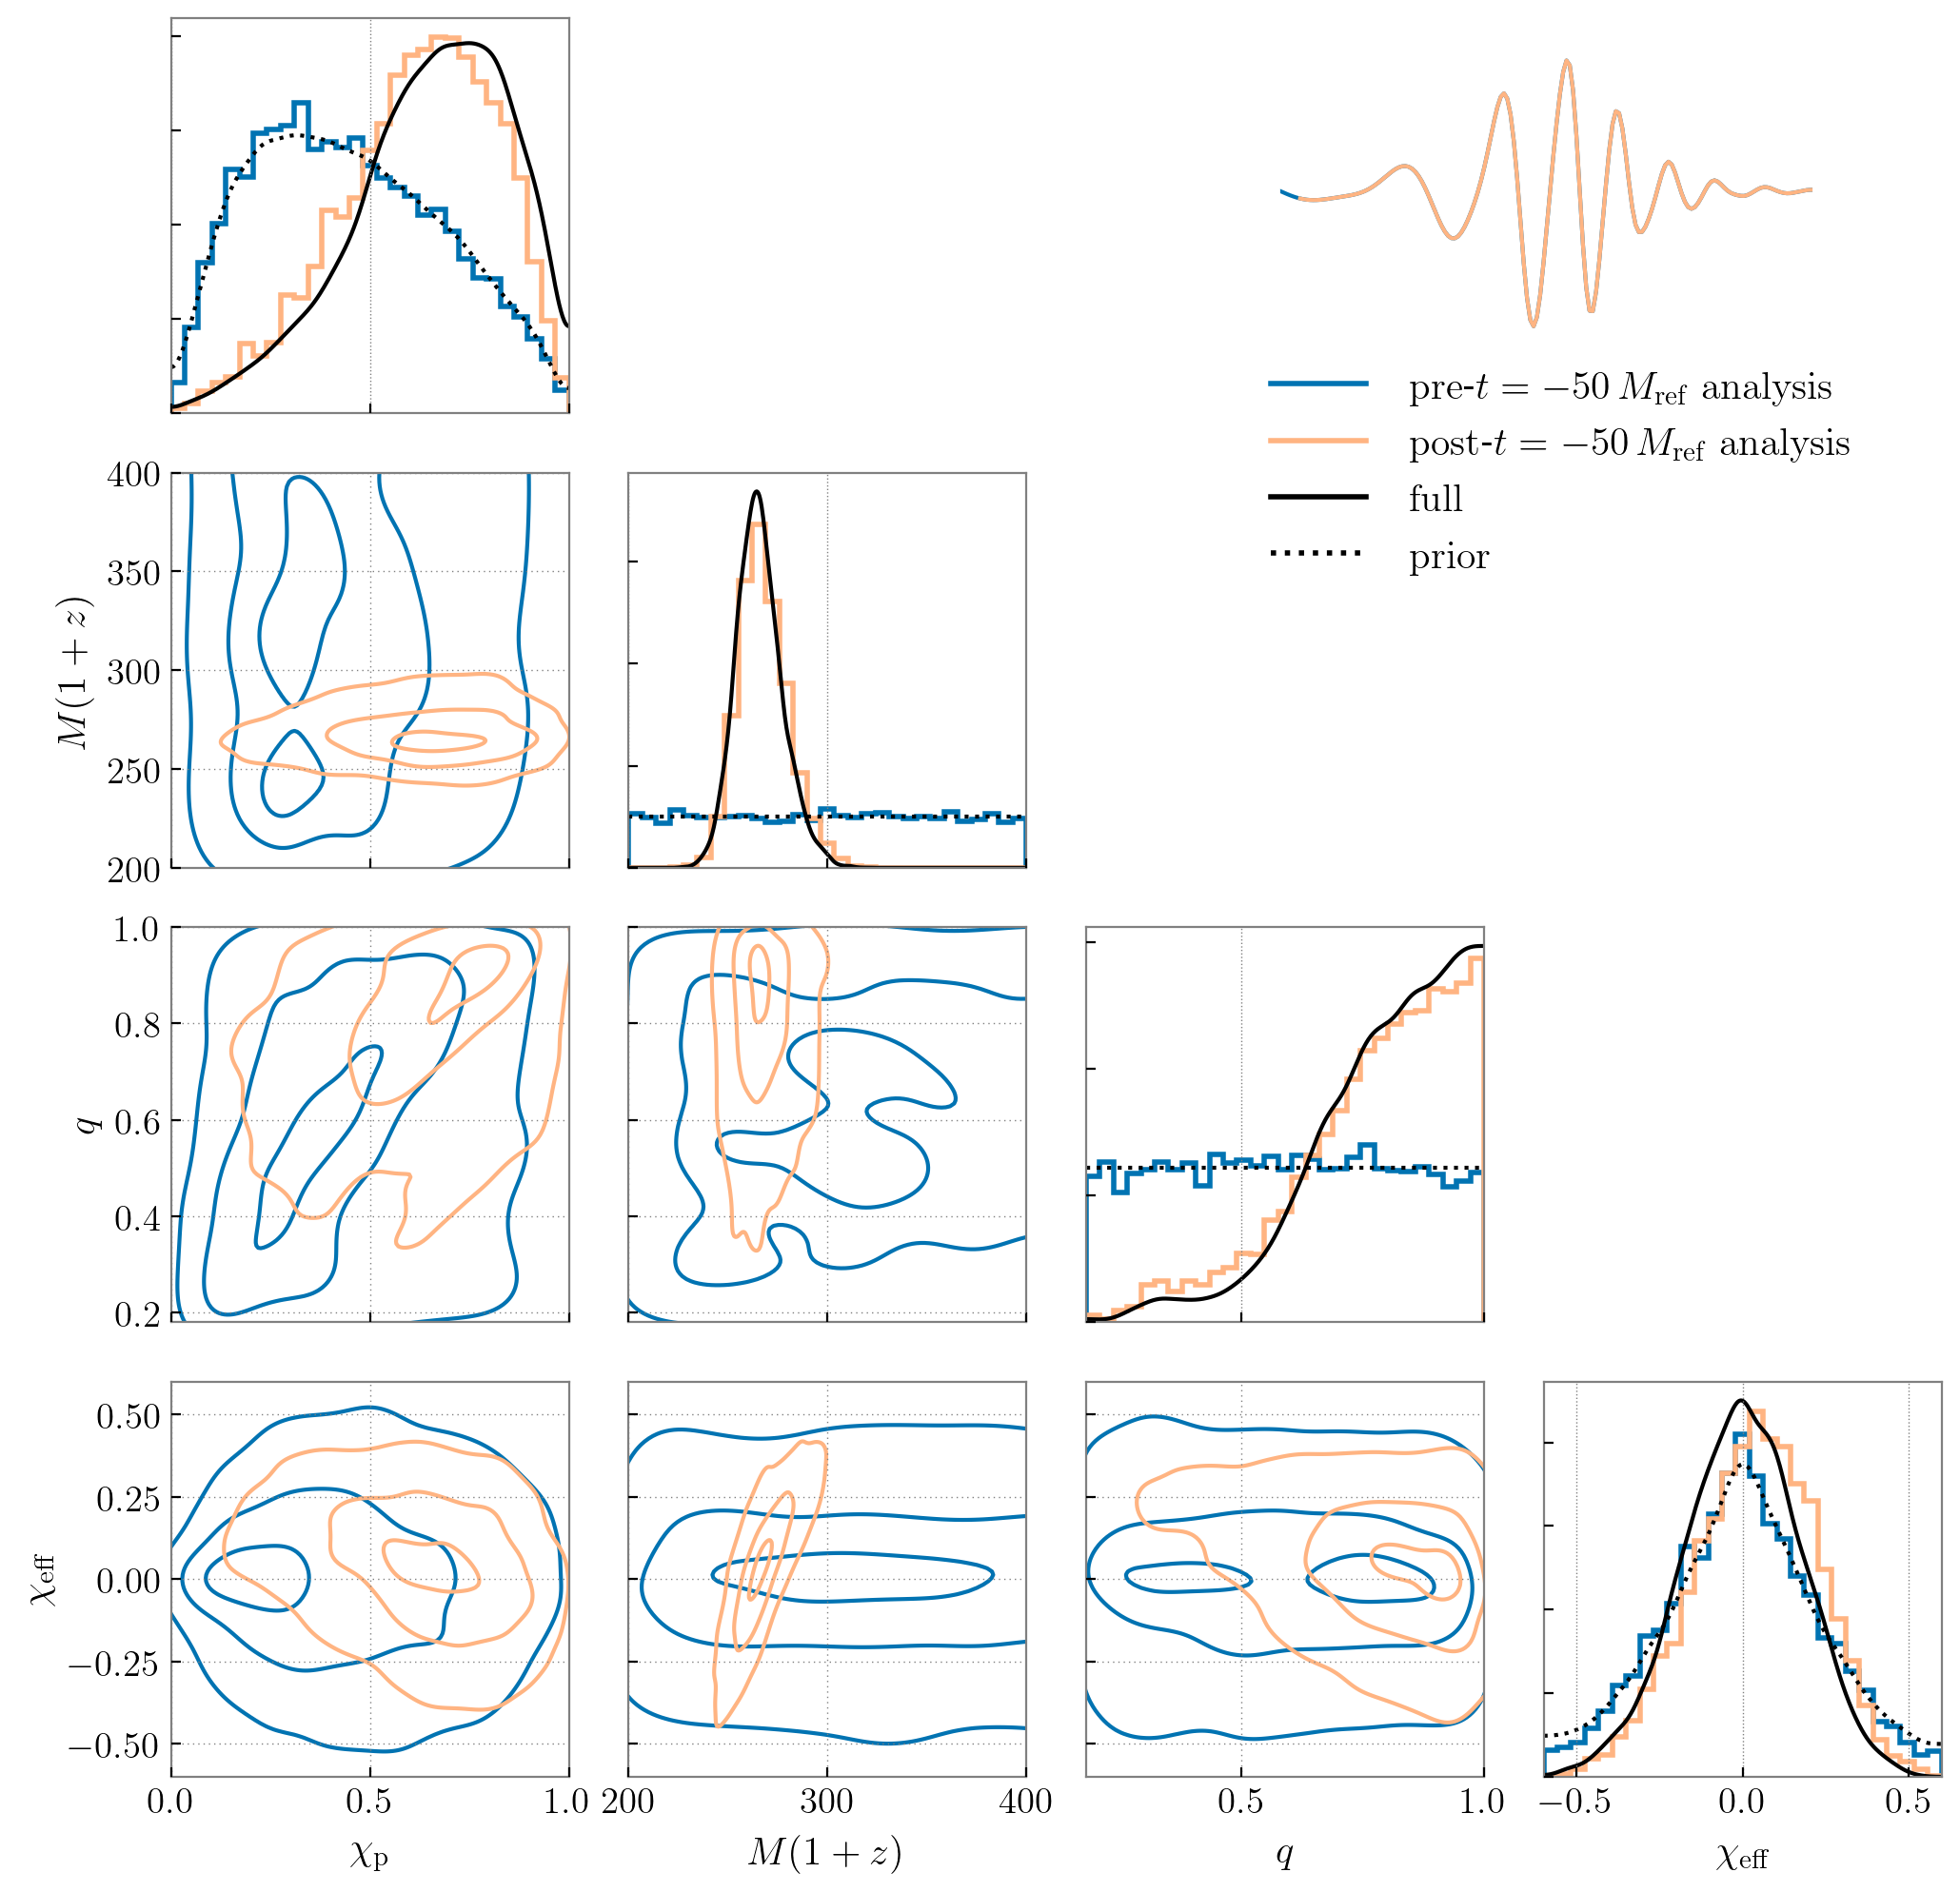

m40M
m37.5M
m35M
m32.5M
m30M
m27.5M
m25M
m22.5M
m20M
m17.5M
m15M
m12.5M
m10M
m7.5M
m5M
m2.5M
0M
2.5M
5M
7.5M
10M
12.5M
15M
17.5M
20M
30M
40M
50M


In [9]:
keys = list(labels_dict)   
ndim = len(keys)
bins = 30
labelsize = 15

# Cycle through each tc
for r, tc in enumerate(tcutoffs):
    
    print(tc)

    fig = plt.figure(figsize=(12,12))
    
    # Cycle through each parameter
    for i,key in enumerate(keys):

        # Plot the marginal 1D posterior(s) (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))

        bounds = bounds_dict[key]

        # Plot the posterior samples for before and after the cuts
        for n, x in enumerate(['insp', 'rd']):
            
            color=cp[0] if n==0 else cp2[1]

            try:
                posterior = dict_to_plot[f'{x} {tc}'][key]
            except: 
                posterior = dict_to_plot['prior'][key]

            ax.hist(posterior,bins=np.linspace(*bounds,bins), rasterized=True, density=True, zorder=0, 
                    histtype='step', color=color, lw=2)

        # Add full posterior and prior
        ax.plot(kde_dict['full'][key]['grid'], kde_dict['full'][key]['kde'], color='k')
        if key=='q' or key=='mtot': 
            # uniform priors
            ax.axhline(1/(bounds_dict[key][1] - bounds_dict[key][0]), color='k', ls=':')
        else:
            ax.plot(kde_dict['prior'][key]['grid'], kde_dict['prior'][key]['kde'], color='k', ls=':')

        # Set axis bounds
        ax.set_xlim(*bounds)

        # Turn off tick
        ax.set_yticklabels([])
        ax.grid(axis='y')

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(labels_dict[key],fontsize=labelsize)

        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:

            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):

                # Make a 2D contour plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))

                # Axes bounds
                x_bounds = bounds_dict[key]
                y_bounds = bounds_dict[k]

                # Plot the posterior samples for before and after the cut
                for n, x in enumerate(['insp', 'rd']):
                    
                    color=cp[0] if n==0 else cp2[1]
                    
                    try:
                        posterior_x = dict_to_plot[f'{x} {tc}'][key]
                    except: 
                        posterior_x = dict_to_plot['prior'][key]
                    try:
                        posterior_y = dict_to_plot[f'{x} {tc}'][k]
                    except: 
                        posterior_y = dict_to_plot['prior'][k]
                    posterior_df = pd.DataFrame({key:posterior_x, k:posterior_y})

                    # Use seaborn to make a kde plot
                    sns.kdeplot(data=posterior_df, 
                                x=key, y=k,
                                ax=ax, 
                                levels=[0.1, 0.5, 0.90],
                                fill=False,
                                zorder=2, 
                                color=color)

                # Set axis bounds
                ax.set_xlim(*x_bounds)
                ax.set_ylim(*y_bounds)
                ax.grid(True,dashes=(1,3))

                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(labels_dict[k],fontsize=labelsize)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(labels_dict[key],fontsize=labelsize)
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])
    
    # Plot waveform 
    ax = fig.add_subplot(ndim,ndim,3)
    ax.set_visible(False)
    gs = ax.get_gridspec()
    wf_ax = fig.add_subplot(gs[0, 2:])
    wf_ax.axis('off')
    mask = L1_times>tc_floats[tc]
    wf_ax.plot(L1_times, L1_maxP_strain_wh, color = cp[0], zorder=1)
    wf_ax.plot(L1_times[mask], L1_maxP_strain_wh[mask], color = cp2[1], zorder=1)
    wf_ax.axvspan(-100, -55, color='white', zorder=2)
    wf_ax.axvspan(70, 100, color='white', zorder=2)
    wf_ax.set_xlim(-100,100)
    wf_ax.set_ylim(-4.5, 3.5)
    
    # Legend
    handles = [
        Line2D([], [], color=cp[0], 
               label=f'$\mathrm{{pre}}$-$t={tc_lbls[tc][:-1]}\, M_\mathrm{{ref}}~\mathrm{{analysis}}$'),
        Line2D([], [], color=cp2[1], 
               label=f'$\mathrm{{post}}$-$t={tc_lbls[tc][:-1]}\,M _\mathrm{{ref}}~\mathrm{{analysis}}$'),
        Line2D([], [], color='k',label=r'$\mathrm{full}$'),
        Line2D([], [], color='k', ls=':', label=r'$\mathrm{prior}$')
    ]
    leg = wf_ax.legend(handles=handles, loc='lower left', fontsize=labelsize, bbox_to_anchor=(0.16,-0.5), 
                       handlelength=3)
    
    for i, h in enumerate(handles):
        leg.get_lines()[i].set_linewidth(2)

    plt.subplots_adjust(hspace=0.15, wspace=0.15)
    plt.savefig(f'for_gif_02/frame_{tc}.png',bbox_inches='tight',dpi=200)
    
    if r==0:
        plt.show()
    else:
        plt.close()

In [10]:
# Assemble into a gif
frames = []
for tc in tcutoffs:
    image = imageio.v2.imread(f'for_gif_02/frame_{tc}.png')
    frames.append(image)
fps = 1.5
imageio.mimsave('gif_02.gif', frames, fps=fps)  